# HHHV - Baseline Model

### Setup

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=84d60b8e4c0a013db8c3b55dfc5480bf221948bc51d72f493667ea668ac7185b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=3f03a7878b79b482432835d99763a577636d6ae1204769eec15bbbe2b148e9d0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


## Libraries

In [28]:
import gc
import json # json file processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

import cv2
import tifffile as tiff
import matplotlib.pyplot as plt

# Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Model
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

# Train
from sklearn.model_selection import StratifiedShuffleSplit

from typing import Optional, List
from datetime import datetime

## Utilities

In [3]:
def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = list(json_file)
    
    json_data = []
    for json_str in data:
        json_data.append(json.loads(json_str))
        
    return pd.DataFrame(json_data)


def get_cartesian_coords(
    coords, 
    img_height
):
    """
    Reference: https://www.kaggle.com/code/leonidkulyk/eda-hubmap-hhv-\
    interactive-annotations?scriptVersionId=130603722&cellId=7
    """
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys


def read_tiff(
    image_id, 
    source = "train"
):
    array = tiff.imread(data_path/f"{source}/{image_id}.tif")
    # image_array = Image.fromarray(array)
    return array


def plot_tile(
    ax,
    item,
    annotate: Optional[bool] = False,
    is_transformed: Optional[bool] = False,
    cmap: Optional[str] = 'rainbow'
):
    """
    Plot a specified tile.
    
    Parameters
    ----------
    ax
        A dataframe with the metadata on the samples.
    item
        A pytorch Dataset instance.
    annotate
        Optionally, whether to annotate the samples or not.
    is_transformed
        Optionally, whether the dataset has been transformed 
        specifically to a pytorch tensor.
    cmap : str
        The Colormap instance or registered colormap name used to map scalar data to colors.
        This parameter is ignored if X is RGB(A).
    """
    # Show image.
    if is_transformed:
        ax.imshow(np.transpose(item['image'], [1, 2, 0]))
    else:
        ax.imshow(item['image'])
    
    # Add annotations if necessary.
    if annotate:
        # combined_mask = np.stack(item['masks'], axis=0).sum(axis=0)
        # combined_mask = np.where(combined_mask > 0, 1, 0)
        ax.imshow(item['masks'], cmap=cmap, alpha=0.3)

    ax.axis("off")
    ax.set_title(item['id'])
    
    
def plot_tiles(
    dataset,
    indices: list,
    annotate: bool = False,
    cols: int = 2,
    figsize: tuple = (18, 5),
    is_transformed: Optional[bool] = False,
    cmap: Optional[str] = 'rainbow'
):
    """
    Plot a grid of specified tiles.
    
    Parameters
    ----------
    hhhv_dataset
        A pytorch Dataset object.
    indices
        A list of the item indices to plot.
    annotate
        Optionally, whether to annotate the samples or not.
    cols
        Optionally, the number of columns for the grid.
    figsize
        Optionally, a tuple containg the figure size in the form (width, height).
    is_transformed
        Optionally, whether the dataset has been transformed 
        specifically to a pytorch tensor.
    cmap : str
        The Colormap instance or registered colormap name used to map scalar data to colors.
        This parameter is ignored if X is RGB(A).
    """
    # Infer rows.
    items = len(indices)
    rows, x = items // cols, items % cols # x carries the reminder if it exists.
    rows = rows if x == 0 else rows + 1
    
    # Set up figure.
    if not (isinstance(figsize, tuple) and len(figsize)==2):
        raise ValueError("Please provide a valid figsize i.e. (width, height)")
    fig = plt.figure(figsize=(figsize[0], figsize[1] * rows))
    
    # Plotting loop.
    for idx, index in enumerate(indices):
        ax = fig.add_subplot(rows, cols, idx + 1)
        plot_tile(ax, dataset[index], annotate, is_transformed, cmap=cmap)
        
    plt.tight_layout()

## Data

In [4]:
# Config.
data_path = Path('/kaggle/input/hubmap-hacking-the-human-vasculature')

In [5]:
train_data = read_json(data_path/'polygons.jsonl')
wsi_metadata = pd.read_csv(data_path/'wsi_meta.csv')
tile_metadata = pd.read_csv(data_path/'tile_meta.csv')

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1633 non-null   object
 1   annotations  1633 non-null   object
dtypes: object(2)
memory usage: 25.6+ KB


In [7]:
for item in train_data.query("id == 'd850250778f2'").squeeze()['annotations']:
    print(item['type'])

unsure
unsure
unsure
unsure
unsure


In [8]:
def count_label_types(
    annotations_label,
    target_label_type: Optional[str] = 'blood_vessel'
):
    """
    Count how many labels exist that belong to a given group.
    """
    label_count = 0
    for annotation_label in annotations_label:
        label_type = annotation_label['type']
        if label_type == target_label_type:
            label_count += 1
    return label_count

In [9]:
# Count number of labels of the blood_vessel type.
train_data['label_counts'] = train_data['annotations'].apply(count_label_types)
# Filter out the instances without labels.
train_data = train_data.query("label_counts > 0").reset_index(drop=True)

## HHHV Dataset

In [10]:
class HHHVDataset(Dataset):
    """
    Reads in images, transfroms pixel values and serves a dictionary containing the image ids,
    image tensors and the label masks.
    """
    def __init__(
        self,
        data: pd.DataFrame,
        transforms: Optional[list] = None,
        target_type: Optional[str] = 'single',
        label_types: Optional[list] = ['blood_vessel'],
        include_labels: Optional[bool] = False
    ):
        """
        Instantiate the HHHHBDataset.
        
        Parameters
        ----------
        data
            A dataframe with a row for each biopsy image.
        transforms
            Optionally, a list of transforms to apply to the feature data. (Augmentations).
        target_type
            Optionally, the type of target, single i.e. stack all masks into one mask of ones and zeros,
            multi i.e. keep the masks separate, default single.
        label_types
            Optionally, the labels for whose masks to extract, default blood_vessel.
        include_labels
            Optionally, include a labels key in the instance dictionary returned, default is False.
        """
        self.data = data
        self.transforms = transforms
        self.target_type = target_type
        self.label_types = label_types
        self.include_labels = include_labels
        
        self.types = {
            "blood_vessel": 1,
            "glomerulus": 2,
            "unsure": 3,
        }
        
    def __len__(
        self
    ):
        return self.data['id'].nunique()
    
    def __get_mask(
        self,
        label: int, 
        coordinates: np.ndarray,
        image_shape: Optional[tuple] = (512, 512)
    ) -> np.ndarray:
        mask = np.zeros(image_shape, dtype=np.int8)
        return cv2.fillPoly(
            mask, pts=coordinates,
            color=(label, label, label)
        )
    
    def __getitem__(
        self, 
        idx: int
    ) -> dict:      
        # Loads an n-channel image from a chip-level dataframe.
        img_metadata = self.data.loc[idx]
        
        # Read in the image.
        img_arr = read_tiff(img_metadata.id)
        
        # Unpack annotations into masks.
        annotations = img_metadata['annotations']
        masks, labels = [], []
        
        for annotation in annotations:
            label_type = annotation['type']
            if label_type in self.label_types:
                masks.append(
                    self.__get_mask(
                        self.types[label_type],
                        np.array(annotation['coordinates']),
                        image_shape = (img_arr.shape[0], img_arr.shape[0])
                    )
                )
                labels.append(label_type)
                
        if self.target_type == 'single':
            if len(masks) == 0:
                raise ValueError(f"Empty labels for {img_metadata['id']}")
                
            masks = np.stack(masks, axis=0).sum(axis=0)
            
            # Apply data augmentations, if provided.
            if self.transforms:
                augmented = self.transforms(image=img_arr, mask=masks)
                # Get augmentations.
                img_arr = augmented['image']
                masks = augmented['mask']
        
        # Prepare the dictionary for item.
        item = {
            "id": img_metadata["id"], 
            "image": img_arr, # Change from HxWxC to CxHxW for pytorch. ToTensorV2
            "masks": masks
        }
        
        if self.include_labels:
            item["labels"] = labels
    
        return item

In [11]:
# Test Augmentations.
transforms = A.Compose([
    A.Resize(512, 512),
    A.VerticalFlip(0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    ToTensorV2()
])

# Dataset without transforms.
hhhv_dataset = HHHVDataset(data=train_data)

# Dataset with transforms.
hhhv_datasetT= HHHVDataset(data=train_data, transforms=transforms) 

### Visualization

#### Without Transforms

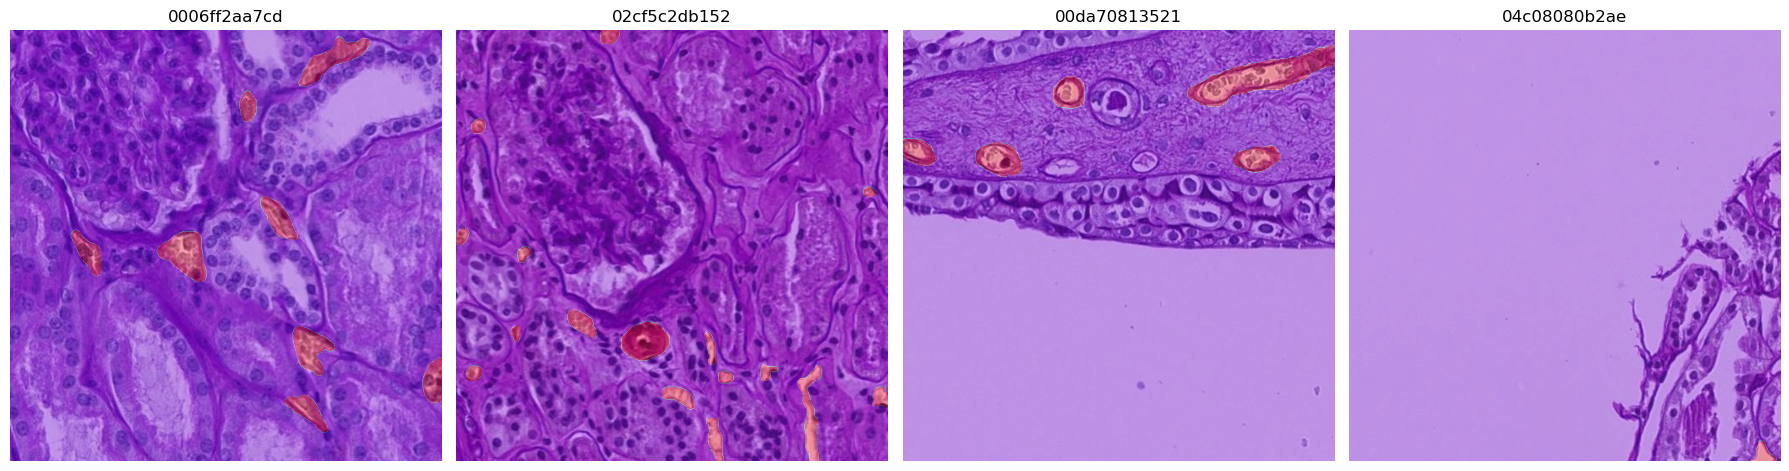

In [12]:
plot_tiles(hhhv_dataset, [0, 20, 11, 30], annotate=True, cols=4)

#### With Transforms

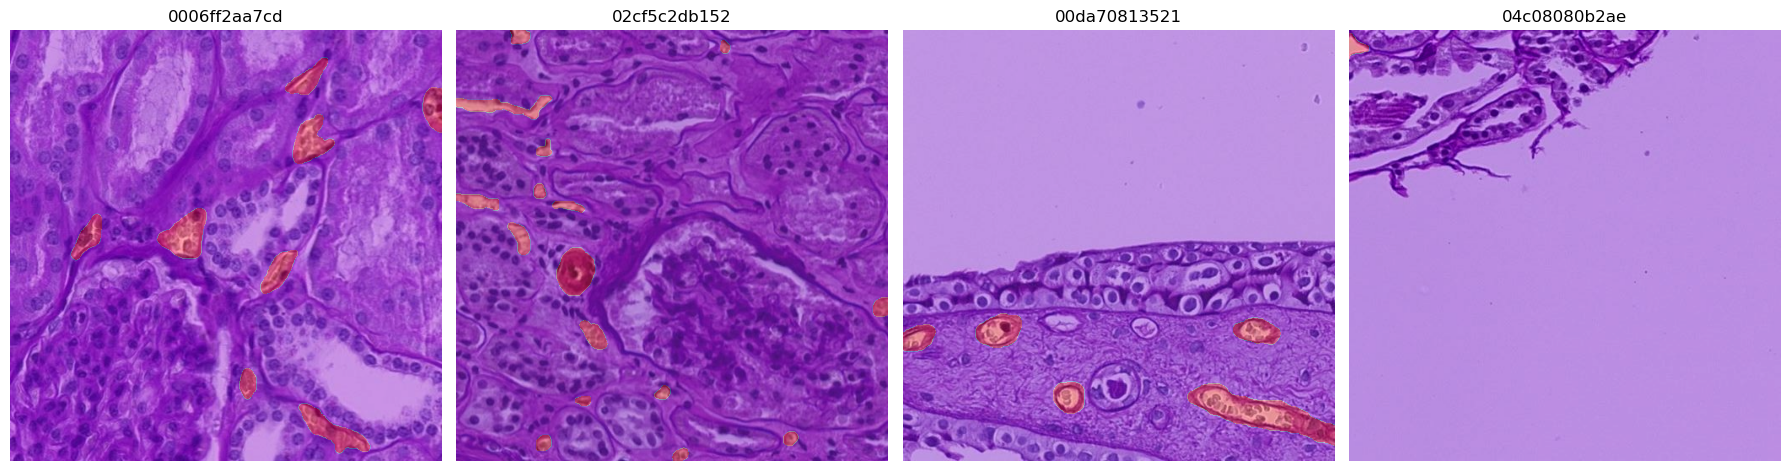

In [13]:
plot_tiles(hhhv_datasetT, [0, 20, 11, 30], annotate=True, cols=4, is_transformed=True)

## HHHV Model

In [14]:
# The model.
class HHHVModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        """
        Instantiate the HHHHBModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).
        
        Parameters
        ----------
        arch
            The architecture code.
        encoder_name
            The name of the encoder.
        in_channels
            The number of channels of the input image files.
        out_classes
            The number of classes that define the label mask.
        """
        super().__init__()
        self.save_hyperparameters()
        
        # Instantiate datasets, model, and trainer params if provided.
        self.model = self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.learning_rate = self.hparams.get("lr", 1e-3)

    ## Required LightningModule methods ##

    def forward(self, image: torch.Tensor):
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.
        
        Parameters
        ----------
        batch
            A dictionary of items from HHHVDataset of the form
            {'id': list[int], 'image': list[torch.Tensor], 'mask': list[torch.Tensor]]}
        batch_idx
            The batch number.
        """
        # Load images and labels
        x = batch["image"]
        y = batch["masks"].long()
        # Forward pass
        logits = self.forward(x) 
        loss = self.loss_fn(logits, y)
        # Log batch loss.
        self.log("train_score", loss, prog_bar=True) 
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.
        
        Parameters
        ----------
        batch
            A dictionary of items from HHHHBDataset of the form
            {'id': list[int], 'image': list[torch.Tensor], 'mask': list[torch.Tensor]}
        batch_idx
            The batch number
        """
        # Load images and labels
        x = batch["image"]
        y = batch["masks"]
        # Forward pass 
        logits = self.forward(x)
        # Log batch dice.
        val_score = self.loss_fn(logits, y)
        self.log("val_score", val_score, prog_bar=True)
        return val_score

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return opt

### Validation Dataset
Validation split based on sex and race.

In [15]:
wsi_tile_metadata = pd.merge(left=wsi_metadata, right=tile_metadata, on='source_wsi', how='right')
wsi_tile_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7033 entries, 0 to 7032
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   source_wsi  7033 non-null   int64  
 1   age         1633 non-null   float64
 2   sex         1633 non-null   object 
 3   race        1633 non-null   object 
 4   height      1633 non-null   float64
 5   weight      1633 non-null   float64
 6   bmi         1633 non-null   float64
 7   id          7033 non-null   object 
 8   dataset     7033 non-null   int64  
 9   i           7033 non-null   int64  
 10  j           7033 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 659.3+ KB


Some tiles are missing the wsi metadata, only the labeled tiles do.

In [16]:
labeled_tile_metadata = wsi_tile_metadata.query("id in @train_data.id").reset_index(drop=True)
labeled_tile_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   source_wsi  1622 non-null   int64  
 1   age         1622 non-null   float64
 2   sex         1622 non-null   object 
 3   race        1622 non-null   object 
 4   height      1622 non-null   float64
 5   weight      1622 non-null   float64
 6   bmi         1622 non-null   float64
 7   id          1622 non-null   object 
 8   dataset     1622 non-null   int64  
 9   i           1622 non-null   int64  
 10  j           1622 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 139.5+ KB


In [17]:
# Combine sex and race.
labeled_tile_metadata['sex_race'] = labeled_tile_metadata['sex'] + '_' + labeled_tile_metadata['race']
train_data = pd.merge(left=train_data, right=labeled_tile_metadata[['id', 'sex_race']], on='id', how='left')

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, val_idx in split.split(train_data, train_data['sex_race']):
    train_metadata, val_metadata = train_data.loc[train_idx].reset_index(drop=True),\
                                    train_data.loc[val_idx].reset_index(drop=True)

In [19]:
train_metadata.shape, val_metadata.shape

((1378, 4), (244, 4))

### Train/Val Configuration

In [20]:
# Train transforms.
train_transforms = A.Compose([
    A.Resize(640, 640),
    A.VerticalFlip(0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

# Validation transforms.
val_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

In [21]:
# Dataset config.
num_workers = 2
batch_size =  4

# Train set.
train_loader = DataLoader(
    HHHVDataset(data=train_metadata, transforms=train_transforms), 
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=True,
    pin_memory=True
)

# Valid set.
val_loader = DataLoader(
    HHHVDataset(data=val_metadata, transforms=val_transforms), 
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=False, 
    pin_memory=True
)

In [22]:
# Set up model object.
hhhv_model = HHHVModel("unet", "resnet50", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 288MB/s]


In [23]:
# Set up call backs.
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_score", mode="max", verbose=True)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="val_score", patience=4, mode="max",verbose=True)
model_summary_callback = pl.callbacks.ModelSummary(max_depth=1)

# Set up trainer.
trainer = pl.Trainer(accelerator="auto", callbacks=[checkpoint_callback, early_stopping_callback, model_summary_callback])

In [24]:
# Fit the model.
trainer.fit(
    hhhv_model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
hhhv_model.trainer.callbacks[0].best_score

tensor(0.6719, device='cuda:0')

### Save Best Model

In [30]:
now = datetime.now()
current_time = now.strftime("%d_%m_%Y")
current_time

'24_07_2023'

In [31]:
model_weight_path = f'/kaggle/working/hhhv_baseline_model_{current_time}.pt'
torch.save(hhhv_model.state_dict(), model_weight_path)